# Monochrome camera calibration
One of the great disadvantages with using lenses is the distortion it introduces to the image. For vacation images, this is usually not a problem, but when we use the image to describe the physical surroundings it becomes important that the images are representative of the scene it captures. An easy way to get an indication of how distorted an image is by looking at what is supposed to be straight lines since they will appear curved.

We have been given calibration data for 4 different cameras, but images from 2 cameras. The given camera pair is 2 & 3, where 2 is left, and 3 is right.

In [9]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to parse the calibration parameters from the text file
def parse_calibration_file(file_path, camera_number):
    # Initialize variables
    mtx = None
    dist = None
    R = None
    T = None
    R_rect = None
    P_rect = None

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Loop through lines and parse the relevant data
        for line in lines:
            if line.startswith("K_" + camera_number + ":"):
                # Extract K_xx matrix values
                k_values = list(map(float, line.strip().split()[1:]))
                mtx = np.array(k_values).reshape((3, 3))
            elif line.startswith("D_" + camera_number + ":"):
                # Extract D_xx distortion coefficients
                d_values = list(map(float, line.strip().split()[1:]))
                dist = np.array(d_values)
            elif line.startswith("R_" + camera_number + ":"):
                # Extract K_xx matrix values
                k_values = list(map(float, line.strip().split()[1:]))
                R = np.array(k_values).reshape((3, 3))
            elif line.startswith("T_" + camera_number + ":"):
                # Extract D_xx distortion coefficients
                d_values = list(map(float, line.strip().split()[1:]))
                T = np.array(d_values)
            elif line.startswith("R_rect_" + camera_number + ":"):
                k_values = list(map(float, line.strip().split()[1:]))
                R_rect = np.array(k_values).reshape((3, 3))
            elif line.startswith("P_rect_" + camera_number + ":"):
                k_values = list(map(float, line.strip().split()[1:]))
                P_rect = np.array(k_values).reshape((3, 4))
            


    return mtx, dist, R, T, R_rect, P_rect

calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

## Function find chessboards

In [ ]:
def Find_chessboards(path_chess, side, show_boards=False):
    import cv2
    import glob
    import numpy as np

    # Chessboard sizes and their counts
    chessboard_sizes = {
        (11, 7): 2,  # 2 chessboards of size 11x7
        (5, 7): 10,  # 10 chessboards of size 5x7
        (15, 5): 1,  # 1 chessboard of size 15x5
    }

    # Expand the sizes into a list
    chessboard_list = [
        (size[0], size[1]) for size, count in chessboard_sizes.items() for _ in range(count)
    ]

    # Build a dictionary to count expected chessboards per size
    chessboard_counts = {}
    for size in chessboard_list:
        chessboard_counts[size] = chessboard_counts.get(size, 0) + 1

    # Arrays to store object points and image points from all images
    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in image plane

    # List to store images where not all chessboards were detected
    images_with_missing_boards = []

    # Load images
    images = glob.glob(path_chess + 'data/*.png')
    assert images, "No images found in the specified path."

    # Define termination criteria for corner refinement
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)

    # Process each image
    for fname in images:
        img = cv2.imread(fname)
        original_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Original grayscale image

        # Initialize per-image lists and counts
        img_objpoints = []  # Object points for this image
        img_imgpoints = []  # Image points for this image
        found_chessboard_counts = {}

        # First attempt: Without adaptive thresholding
        gray = original_gray.copy()

        if side == "03":
            gray = cv2.equalizeHist(gray)

        not_found_chessboards = []

        for nb_vertical, nb_horizontal in chessboard_list:
            ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

            if ret:

                if side == "02":
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)
                if side == "03":
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                # Prepare object points
                objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                # Append points to the per-image lists
                img_objpoints.append(objp)
                img_imgpoints.append(corners)

                # Update found chessboard counts
                size = (nb_vertical, nb_horizontal)
                found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                # Mask the detected region
                cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                if show_boards:
                        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
                        cv2.imshow('Detected Chessboard (Without Thresholding)', img)
                        if cv2.waitKey(200) & 0xFF == ord('q'):
                            break

            else:
                not_found_chessboards.append((nb_vertical, nb_horizontal))

        # Second attempt: Retry not-found chessboards with adaptive thresholding
        gray = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2
        )

        not_found_chessboards2 = []

        for nb_vertical, nb_horizontal in not_found_chessboards:
            ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

            if ret:
                
                # Refine corner positions
                corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                # Prepare object points
                objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                # Append points to the per-image lists
                img_objpoints.append(objp)
                img_imgpoints.append(corners)

                # Update found chessboard counts
                size = (nb_vertical, nb_horizontal)
                found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                # Mask the detected region
                cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                if show_boards:
                        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
                        cv2.imshow('Detected Chessboard (Without Thresholding)', img)
                        if cv2.waitKey(200) & 0xFF == ord('q'):
                            break

            else:
                if side == "02":
                    pass  # No further action needed
                if side == "03":
                    not_found_chessboards2.append((nb_vertical, nb_horizontal))

        if side == "03":
            # Third attempt: Retry not-found chessboards with adaptive thresholding
            original_gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            roi_x, roi_y, roi_w, roi_h = 1120, 150, 150, 270  # Example values
            gray_roi = original_gray2[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
            gray = cv2.equalizeHist(gray_roi)

            gray = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 4
            )

            for nb_vertical, nb_horizontal in not_found_chessboards2:
                ret, corners = cv2.findChessboardCornersSB(gray, (nb_vertical, nb_horizontal))

                if ret:
                    # Refine corner positions
                    corners = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

                    # Adjust corner positions to match the original image
                    corners[:, 0, 0] += roi_x  # Add ROI x-offset
                    corners[:, 0, 1] += roi_y  # Add ROI y-offset

                    # Prepare object points
                    objp = np.zeros((nb_vertical * nb_horizontal, 3), np.float32)
                    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

                    # Append points to the per-image lists
                    img_objpoints.append(objp)
                    img_imgpoints.append(corners)

                    # Update found chessboard counts
                    size = (nb_vertical, nb_horizontal)
                    found_chessboard_counts[size] = found_chessboard_counts.get(size, 0) + 1

                    # Mask the detected region
                    cv2.fillConvexPoly(gray, corners.astype(np.int32), 0)

                    # Visualize detection
                    if show_boards:
                        img = cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)
                        cv2.imshow('Detected Chessboard (Without Thresholding)', img)
                        if cv2.waitKey(200) & 0xFF == ord('q'):
                            break
                else:
                    pass  # No further action needed
        
        cv2.destroyAllWindows()

        # Check if all expected chessboards were found in this image
        if found_chessboard_counts == chessboard_counts:
            # All expected chessboards found; add points to main lists
            objpoints.extend(img_objpoints)
            imgpoints.extend(img_imgpoints)
        else:
            # Not all chessboards found; discard points from this image
            images_with_missing_boards.append(fname)

    print(f"Images with missing chessboards: {len(images_with_missing_boards)} out of {len(images)}")
    return objpoints, imgpoints, original_gray

## Rectification

### Calculate camera matrix for both cameras

In [13]:
path_chess_2 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_02/'
path_chess_3 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

objpoints2, imgpoints2, original_gray2 = Find_chessboards(path_chess_2, "02", show_boards=False)
objpoints3, imgpoints3, original_gray3 = Find_chessboards(path_chess_3, "03", show_boards=False)

ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, original_gray2.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)
ret3, mtx3, dist3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints3, imgpoints3, original_gray3.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)

Images with missing chessboards: 8 out of 19
Images with missing chessboards: 11 out of 19


### Reprojection error for each camera, histogram

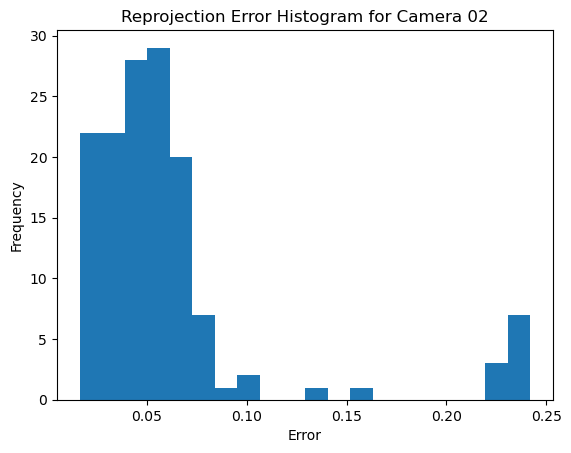

In [10]:
reprojection_errors = []
for i in range(len(objpoints2)):
    imgpoints2_proj, _ = cv2.projectPoints(objpoints2[i], rvecs2[i], tvecs2[i], mtx2, dist2)
    error = cv2.norm(imgpoints2[i], imgpoints2_proj, cv2.NORM_L2)/len(imgpoints2_proj)
    reprojection_errors.append(error)

# Plot histogram
import matplotlib.pyplot as plt

plt.hist(reprojection_errors, bins=20)
plt.title('Reprojection Error Histogram for Camera 02')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

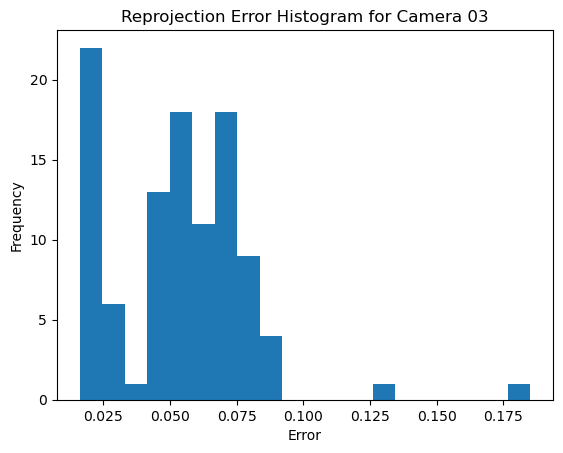

In [11]:
reprojection_errors = []
for i in range(len(objpoints3)):
    imgpoints3_proj, _ = cv2.projectPoints(objpoints3[i], rvecs3[i], tvecs3[i], mtx3, dist3)
    error = cv2.norm(imgpoints3[i], imgpoints3_proj, cv2.NORM_L2)/len(imgpoints3_proj)
    reprojection_errors.append(error)

# Plot histogram
import matplotlib.pyplot as plt

plt.hist(reprojection_errors, bins=20)
plt.title('Reprojection Error Histogram for Camera 03')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

### Show rectified images side by side

In [14]:
path_raw_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/'
path_raw_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/'

In [23]:
# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

# Parse the calibration file
_ , _ , R_02 , T_02, _ , _ = parse_calibration_file(calib_file_path, "02")
_ , _ , R_03 , T_03, _ , _ = parse_calibration_file(calib_file_path, "03")

R_rel = R_03 @ np.linalg.inv(R_02)
T_rel = T_03 - R_rel @ T_02

# Image size
image_size = (1392, 512)

resize_factor = 0.6

# Compute rectification transforms
R2, R3, P2, P3, Q, roi2, roi3 = cv2.stereoRectify(
    mtx2, dist2, mtx3, dist3, image_size, R_rel, T_rel, alpha=0
)

# Generate rectification maps
map1_x, map1_y = cv2.initUndistortRectifyMap(mtx2, dist2, R2, P2, image_size, cv2.CV_32FC1)
map2_x, map2_y = cv2.initUndistortRectifyMap(mtx3, dist3, R3, P3, image_size, cv2.CV_32FC1)

# Paths to left and right images
left_images = sorted(glob.glob(path_raw_seq_1_02 + 'data/*.png'))  # Update path
right_images = sorted(glob.glob(path_raw_seq_1_03 + 'data/*.png'))  # Update path

# Process each image pair
for left_img_path, right_img_path in zip(left_images, right_images):
    # Load images
    img1 = cv2.imread(left_img_path)
    img2 = cv2.imread(right_img_path)

    # Apply rectification
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    # Combine images side by side
    combined = np.hstack((rectified_img1, rectified_img2))

    # Draw epipolar lines
    num_lines = 10  # Number of epipolar lines to draw
    h, w = rectified_img1.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        cv2.line(combined, (0, y), (w * 2, y), (255, 0, 0), 1)

    scaled_combined = cv2.resize(combined, (0, 0), fx=resize_factor, fy=resize_factor)

    # Show the combined image
    cv2.imshow('Rectified Pair with Epipolar Lines', scaled_combined)

    # Wait for a key press to continue
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

### Show as side by side as video

In [22]:
# Paths to left and right images
left_images = sorted(glob.glob(path_raw_seq_1_02 + 'data/*.png'))  # Update path
right_images = sorted(glob.glob(path_raw_seq_1_03 + 'data/*.png'))  # Update path

# Define playback parameters
frame_rate = 10  # Frames per second
delay = int(1000 / frame_rate)  # Delay in milliseconds

for idx, (left_img_path, right_img_path) in enumerate(zip(left_images, right_images)):
    # Load images
    img1 = cv2.imread(left_img_path)
    img2 = cv2.imread(right_img_path)

    # Apply rectification
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    # Combine images side by side
    combined = np.hstack((rectified_img1, rectified_img2))

    # Draw epipolar lines
    num_lines = 10  # Number of epipolar lines to draw
    h, w = rectified_img1.shape[:2]
    step = h // num_lines
    for y in range(0, h, step):
        cv2.line(combined, (0, y), (w * 2, y), (255, 0, 0), 1)

    scaled_combined = cv2.resize(combined, (0, 0), fx=resize_factor, fy=resize_factor)

    # Display the combined image
    cv2.imshow('Rectified Pair with Epipolar Lines', scaled_combined)

    # Wait for the specified delay or until 'q' is pressed to quit
    key = cv2.waitKey(delay) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

### Error between found and given

In [20]:
mtx_given2, dist_given2, _ , _ , R_rect2 , P_rect2 = parse_calibration_file(calib_file_path, "02")
mtx_given3, dist_given3, _ , _ , R_rect3 , P_rect3 = parse_calibration_file(calib_file_path, "03")

error_K_02 = np.linalg.norm(mtx2 - mtx_given2, ord='fro')
error_K_03 = np.linalg.norm(mtx3 - mtx_given3, ord='fro')

error_D_02 = np.linalg.norm(dist2 - dist_given2)
error_D_03 = np.linalg.norm(dist3 - dist_given2)

print(ret2)
print(ret3)

# Projection Matrix Error
error_P_rect_02 = np.linalg.norm(P2 - P_rect2, ord='fro')
error_P_rect_03 = np.linalg.norm(P3 - P_rect3, ord='fro')

print(f"Intrinsic Matrix Error for Camera 02: {error_K_02}")
print(f"Intrinsic Matrix Error for Camera 03: {error_K_03}")
print(f"Distortion Coefficients Error for Camera 02: {error_D_02}")
print(f"Distortion Coefficients Error for Camera 03: {error_D_03}")
print(f"Projection Matrix Error for Camera 02: {error_P_rect_02}")
print(f"Projection Matrix Error for Camera 03: {error_P_rect_03}")

0.7740583178613941
0.37025317719677137
Intrinsic Matrix Error for Camera 02: 160.6296504151595
Intrinsic Matrix Error for Camera 03: 47.399612750454146
Distortion Coefficients Error for Camera 02: 0.9039254799025942
Distortion Coefficients Error for Camera 03: 0.13304408895728148
Projection Matrix Error for Camera 02: 448.11851833596455
Projection Matrix Error for Camera 03: 492.87744795788115


In [22]:
# Provided focal lengths
fx_provided_02 = mtx_given2[0, 0]
fy_provided_02 = mtx_given2[1, 1]

# Computed focal lengths
fx_computed_02 = mtx2[0, 0]
fy_computed_02 = mtx2[1, 1]

# Percentage errors
fx_error_percent_02 = abs(fx_computed_02 - fx_provided_02) / fx_provided_02 * 100
fy_error_percent_02 = abs(fy_computed_02 - fy_provided_02) / fy_provided_02 * 100

print(f"Camera 02 Focal Length fx Error: {fx_error_percent_02:.2f}%")
print(f"Camera 02 Focal Length fy Error: {fy_error_percent_02:.2f}%")

# Provided focal lengths
fx_provided_03 = mtx_given3[0, 0]
fy_provided_03 = mtx_given3[1, 1]

# Computed focal lengths
fx_computed_03 = mtx3[0, 0]
fy_computed_03 = mtx3[1, 1]

# Percentage errors
fx_error_percent_03 = abs(fx_computed_03 - fx_provided_03) / fx_provided_03 * 100
fy_error_percent_03 = abs(fy_computed_03 - fy_provided_03) / fy_provided_03 * 100

print(f"Camera 03 Focal Length fx Error: {fx_error_percent_03:.2f}%")
print(f"Camera 03 Focal Length fy Error: {fy_error_percent_03:.2f}%")

# Provided distortion coefficients
dist_provided_02 = dist_given2.flatten()
dist_provided_03 = dist_given3.flatten()

# Computed distortion coefficients
dist_computed_02 = dist2.flatten()
dist_computed_03 = dist3.flatten()

# Percentage errors for each coefficient
dist_errors_percent_02 = np.abs(dist_computed_02 - dist_provided_02) / np.abs(dist_provided_02) * 100
dist_errors_percent_03 = np.abs(dist_computed_03 - dist_provided_03) / np.abs(dist_provided_03) * 100

print(f"Camera 02 Distortion Coefficients Percentage Errors: {dist_errors_percent_02}")
print(f"Camera 03 Distortion Coefficients Percentage Errors: {dist_errors_percent_03}")

# Sum of absolute values of the provided projection matrix elements
sum_provided_P2 = np.sum(np.abs(P_rect2))
sum_provided_P3 = np.sum(np.abs(P_rect3))

# Relative error as a percentage
relative_error_P2 = error_P_rect_02 / sum_provided_P2 * 100
relative_error_P3 = error_P_rect_03 / sum_provided_P3 * 100

print(f"Camera 02 Projection Matrix Relative Error: {relative_error_P2:.2f}%")
print(f"Camera 03 Projection Matrix Relative Error: {relative_error_P3:.2f}%")

Camera 02 Focal Length fx Error: 15.93%
Camera 02 Focal Length fy Error: 4.95%
Camera 03 Focal Length fx Error: 2.73%
Camera 03 Focal Length fy Error: 3.86%
Camera 02 Distortion Coefficients Percentage Errors: [ 57.98210456 311.78572591  61.58217717 419.40358412 792.558492  ]
Camera 03 Distortion Coefficients Percentage Errors: [  14.07965463   45.11633016   76.12168456 1759.33261585   77.26552014]
Camera 02 Projection Matrix Relative Error: 19.95%
Camera 03 Projection Matrix Relative Error: 19.43%


### Rectify all images in a seq folder

In [25]:
import cv2
import numpy as np
import os
import glob

# Paths
path_raw_seq_1_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data/'
path_raw_seq_1_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/data/'
output_path_02 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect'
output_path_03 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_03/data_rect'

path_chess_2 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_02/'
path_chess_3 = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib/image_03/'

# Path to the calibration text file
calib_file_path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/calib_cam_to_cam.txt'

objpoints2, imgpoints2, original_gray2 = Find_chessboards(path_chess_2, "02")
objpoints3, imgpoints3, original_gray3 = Find_chessboards(path_chess_3, "03")

ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints2, imgpoints2, original_gray2.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)
ret3, mtx3, dist3, rvecs3, tvecs3 = cv2.calibrateCamera(objpoints3, imgpoints3, original_gray3.shape[::-1], None, None, flags = cv2.CALIB_USE_LU)

_ , _ , R_02 , T_02, _ , _ = parse_calibration_file(calib_file_path, "02")
_ , _ , R_03 , T_03, _ , _ = parse_calibration_file(calib_file_path, "03")

R_rel = R_03 @ np.linalg.inv(R_02)
T_rel = T_03 - R_rel @ T_02

# Image size
image_size = (1392, 512)

resize_factor = 0.6

# Compute rectification transforms
R2, R3, P2, P3, Q, roi2, roi3 = cv2.stereoRectify(
    mtx2, dist2, mtx3, dist3, image_size, R_rel, T_rel, alpha=0
)

# Generate rectification maps
map2_x, map2_y = cv2.initUndistortRectifyMap(mtx2, dist2, R2, P2, image_size, cv2.CV_32FC1)
map3_x, map3_y = cv2.initUndistortRectifyMap(mtx3, dist3, R3, P3, image_size, cv2.CV_32FC1)


if not os.path.exists(output_path_02):
    os.makedirs(output_path_02)

if not os.path.exists(output_path_03):
    os.makedirs(output_path_03)

# Get the list of images in the input path
image_files2 = sorted(glob.glob(os.path.join(path_raw_seq_1_02, '*.png')))
# Get the list of images in the input path
image_files3 = sorted(glob.glob(os.path.join(path_raw_seq_1_02, '*.png')))

# Process each image
for image_file in image_files2:
    img = cv2.imread(image_file)
    rectified_img2 = cv2.remap(img, map2_x, map2_y, cv2.INTER_LINEAR)

    # Crop the rectified image to the valid region of interest
    x, y, crop_w, crop_h = roi2
    rectified_cropped_img2 = rectified_img2[y:y+crop_h, x:x+crop_w]

    # Save the cropped rectified image
    output_file = os.path.join(output_path_02, os.path.basename(image_file))
    cv2.imwrite(output_file, rectified_cropped_img2)
    print(f"Rectified and cropped image saved: {output_file}")

# Process each image
for image_file in image_files3:
    img = cv2.imread(image_file)
    rectified_img3 = cv2.remap(img, map3_x, map3_y, cv2.INTER_LINEAR)

    # Crop the rectified image to the valid region of interest
    x, y, crop_w, crop_h = roi3
    rectified_cropped_img3 = rectified_img3[y:y+crop_h, x:x+crop_w]

    # Save the cropped rectified image
    output_file = os.path.join(output_path_03, os.path.basename(image_file))
    cv2.imwrite(output_file, rectified_cropped_img3)
    print(f"Rectified and cropped image saved: {output_file}")


Images with missing chessboards: 8 out of 19
Images with missing chessboards: 11 out of 19
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000000.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000001.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000002.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Perception for autonomous systems/Final project/34759_final_project_raw/seq_01/image_02/data_rect\0000000003.png
Rectified and cropped image saved: /Users/claes/Documents/Mine dokume